# Plotting Psychometric curves from IBL data pipeline

Welcome back! In this short notebook, we demonstrate how to plot the psychometric curve of the data in a session from the IBL DataJoint pipeline.

If you haven't done so, please step through the notebook [01-Explore IBL data pipeline](01-Explore%20IBL%20data%20pipeline.ipynb) first.

If you haven't set up the datajoint configuration, please step through the notebook [00-Get DataJoint Ready](00-Get%20DataJoint%20Ready.ipynb)

As usual, we import schemas from IBL pipeline from `ibl_pipeline` package.

In [3]:
# behavior data
from ibl_pipeline import behavior

# analysis result on behavioral data
from ibl_pipeline import behavior_analyses

# meta information about subjects and sessions
from ibl_pipeline import subject, acquisition

# A utility function to perform the model fits of the psychometric function
from ibl_pipeline.utils import psychofit as psy

# some standard packages
import numpy as np
import datetime
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In the IBL data pipeline, the psychometric curves have already been computed are saved in the table `behavior_analyses.PsychResultsBlock`. We can browse entries in this table for a particular subject, and the `prob_left_block` marks which prior probability $p(\text{left})$ has been used in the block.


In [4]:
# get psychemtric curves computed for behavioral sessions done by subject with nickname "CSHL_015"
q = behavior_analyses.PsychResultsBlock & (subject.Subject & 'subject_nickname="CSHL_015"')

Let's check the results of sessions collected after 2019-09-15, using restriction to further filter the results:

In [5]:
q & 'session_start_time > "2019-09-15"'

subject_uuid,session_start_time start time,prob_left_block block number representing the probability left,"prob_left 0.5 for trainingChoiceWorld, actual value for biasedChoiceWorld","signed_contrasts contrasts used in this session, negative when on the left",n_trials_stim number of trials for each contrast,"n_trials_stim_right number of reporting ""right"" trials for each contrast","prob_choose_right probability of choosing right, same size as contrasts",threshold,bias,lapse_low,lapse_high
10fd3170-6c52-4cb6-986f-aa73704277c0,2019-09-16 13:44:46,20,0.2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,44.929,-12.7676,0.0582509,0.0621766
10fd3170-6c52-4cb6-986f-aa73704277c0,2019-09-16 13:44:46,50,0.5,=BLOB=,=BLOB=,=BLOB=,=BLOB=,53.3714,20.2507,8.94956e-13,0.128377
10fd3170-6c52-4cb6-986f-aa73704277c0,2019-09-16 13:44:46,80,0.8,=BLOB=,=BLOB=,=BLOB=,=BLOB=,80.6509,65.2483,8.30313e-13,0.0901264
10fd3170-6c52-4cb6-986f-aa73704277c0,2019-09-17 12:53:25,20,0.2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,55.6984,-18.3859,0.0696535,0.0661889
10fd3170-6c52-4cb6-986f-aa73704277c0,2019-09-17 12:53:25,50,0.5,=BLOB=,=BLOB=,=BLOB=,=BLOB=,6.35501,5.85743,0.0644321,1.0
10fd3170-6c52-4cb6-986f-aa73704277c0,2019-09-17 12:53:25,80,0.8,=BLOB=,=BLOB=,=BLOB=,=BLOB=,17.7491,0.0140995,4.20461e-12,0.588134
10fd3170-6c52-4cb6-986f-aa73704277c0,2019-09-18 13:15:24,20,0.2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,22.4853,-4.91344,3.34972e-11,0.0810404
10fd3170-6c52-4cb6-986f-aa73704277c0,2019-09-18 13:15:24,50,0.5,=BLOB=,=BLOB=,=BLOB=,=BLOB=,11.17,-0.00265892,6.38025e-12,0.117684
10fd3170-6c52-4cb6-986f-aa73704277c0,2019-09-18 13:15:24,80,0.8,=BLOB=,=BLOB=,=BLOB=,=BLOB=,23.1028,7.75097,9.16799e-12,0.613259
10fd3170-6c52-4cb6-986f-aa73704277c0,2019-09-19 13:02:55,20,0.2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,41.2042,-22.9518,5.54814e-12,0.0276525


Let's now plot the psychometric curve of the last session on 2019-09-16, containing three blocks with `prob_left` 0.2, 0.5 and 0.8

In [6]:
psych_results = q & {'session_start_time': datetime.datetime(2019, 9, 16, 13, 44, 46)}

In [7]:
psych_results # there are three fits corresponding to three different `prob_left` values

subject_uuid,session_start_time start time,prob_left_block block number representing the probability left,"prob_left 0.5 for trainingChoiceWorld, actual value for biasedChoiceWorld","signed_contrasts contrasts used in this session, negative when on the left",n_trials_stim number of trials for each contrast,"n_trials_stim_right number of reporting ""right"" trials for each contrast","prob_choose_right probability of choosing right, same size as contrasts",threshold,bias,lapse_low,lapse_high
10fd3170-6c52-4cb6-986f-aa73704277c0,2019-09-16 13:44:46,20,0.2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,44.929,-12.7676,0.0582509,0.0621766
10fd3170-6c52-4cb6-986f-aa73704277c0,2019-09-16 13:44:46,50,0.5,=BLOB=,=BLOB=,=BLOB=,=BLOB=,53.3714,20.2507,8.94956e-13,0.128377
10fd3170-6c52-4cb6-986f-aa73704277c0,2019-09-16 13:44:46,80,0.8,=BLOB=,=BLOB=,=BLOB=,=BLOB=,80.6509,65.2483,8.30313e-13,0.0901264


Now let's fetch the fit parameters and behavioral statistics from the table as a list of dictionaries.

In [8]:
dict_results = psych_results.fetch(
    'signed_contrasts', 'prob_choose_right', 'n_trials_stim', 'n_trials_stim_right',
    'threshold', 'bias', 'lapse_low', 'lapse_high', as_dict=True)

Finally, we will loop through the blocks and plot the psychometric curves:

Text(0, 0.5, 'Rightward Choice (%)')

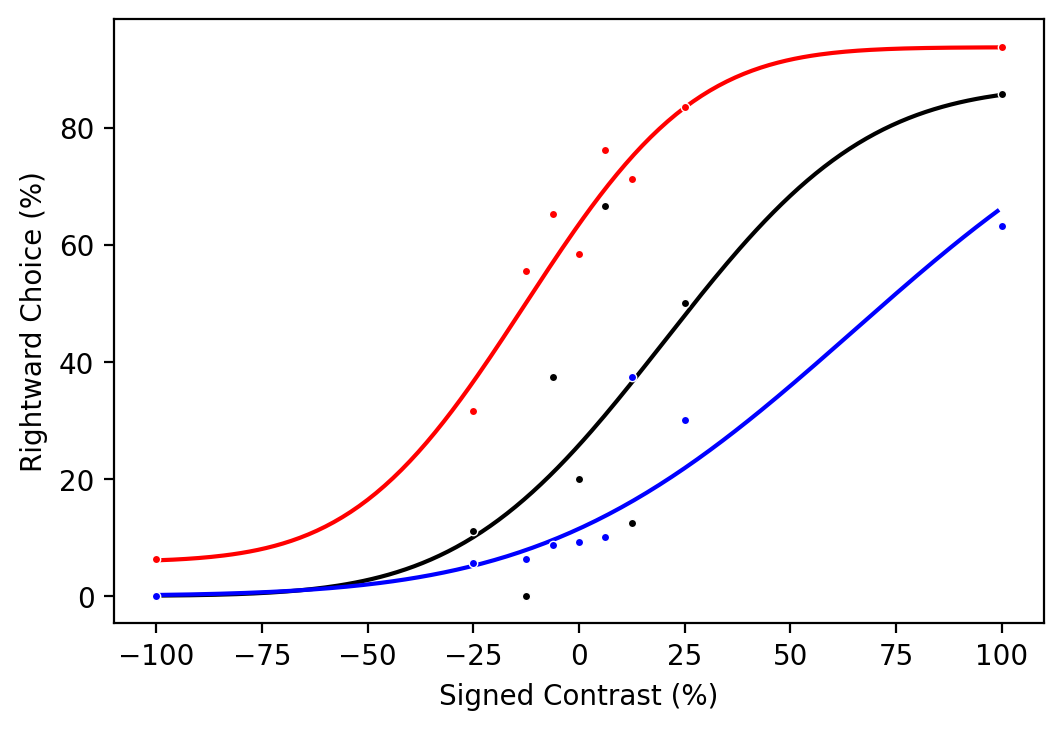

In [9]:
colors = [[1., 0., 0.], [0., 0., 0.], [0., 0., 1.]]
fig, ax = plt.subplots(1, 1, dpi=200)

for result, color in zip(dict_results, colors):
    pars = [result['bias'], result['threshold'], result['lapse_low'], result['lapse_high']]
    contrasts = result['signed_contrasts'] * 100
    contrasts_fit = np.arange(-100, 100)
    prob_right_fit = psy.erf_psycho_2gammas(pars, contrasts_fit) *100
    sns.lineplot(contrasts_fit, prob_right_fit, color=color, ax=ax)
    sns.lineplot(x=contrasts, y=result['prob_choose_right']*100, err_style="bars", linewidth=0, linestyle='None', mew=0.5,
            marker='.', ci=68, color=color, ax=ax)

# add axis labels
ax.set_xlabel('Signed Contrast (%)')
ax.set_ylabel('Rightward Choice (%)')

And that's it! Storing the results of the psychometric curve fits on the behavior data in the DataJoint pipeline allows one to quickly retrieve these values and regenerate the psychometric curves, and to perform any statistical assessment on the fitted parameters. In the next and the last notebook in the series, we will visit how to reproduce a full study figure using data from IBL data pipeline.